# Variations of the IP, the PG and the RMM with the MJO phase
Here we plot variations of various parameters with the MJO. In particular, we plot the ionospheric potential (IP), the fair-weather potential gradient (PG) and the two components of the RMM index. We also plot the sunspot number and outgoing long-wave radiation (OLR).

## Imports

In [2]:
# data processing
import numpy as np
import csv

# plotting the data
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# dates
import datetime as dt

# testing correlation significance
import scipy.stats as st

## Loading the data

In [3]:
map_contrib = np.load('./data/DAILY-IP-MAP-V4.3.npy')
# original data with the shape (number of days, number of latitudes, number of longitudes)
# contains IP values (not normalised) depending on (d, lat, lon)
# d (axis 0) is the number of a day starting with 0 and ending with 4991
# every third day is taken, 0 corresponds to 1 Jan 1980 and 4991 corresponds to 29 Dec 2020
# lat (axis 1) describes the latitude (an integer in [0, 180])
# lon (axis 2) describes the longitude (an integer in [0, 360])

map_contrib /= np.mean(np.sum(map_contrib, axis=(1, 2)))
map_contrib *= 240e3
# normalisation of contributions to the IP to the global mean of 240 kV

ip = np.sum(map_contrib, axis=(1, 2))  # total IP values for different days

In [4]:
map_olr_source = np.load('./data/OLR_41years_NOAA.npy')
# original data with the shape (number of days, number of latitudes, number of longitudes)
# contains OLR values depending on (d, lat, lon)
# d (axis 0) is the number of a day starting with 0 and ending with 14976
# every third day is taken, 0 corresponds to 1 Jan 1980 and 14976 corresponds to 31 Dec 2020
# lat (axis 1) describes the latitude (an integer in [0, 180])
# lon (axis 2) describes the longitude (an integer in [0, 360])
# the data downloaded from https://psl.noaa.gov/mddb2/showDataset.html?datasetID=37

olr_days_ind = np.flatnonzero(np.amin(map_olr_source, axis=(1, 2)) >= 0)
# indices of the days for which the OLR data are available
map_olr = np.take(map_olr_source, olr_days_ind, axis=0)

olr = np.sum(
    np.mean(
        map_olr[:, 75:105, :], axis=2
    ) * (
        np.cos(np.arange(75, 105) * np.pi / 180) -
        np.cos(np.arange(76, 106) * np.pi / 180)
    ), axis=1
) / np.sum(
    np.cos(np.arange(75, 105) * np.pi / 180) -
    np.cos(np.arange(76, 106) * np.pi / 180)
)
# global means of OLR values for 15°S–15°N

In [5]:
d_start = dt.date(1980, 1, 1)  # first date
d_end = dt.date(2021, 1, 1)  # last date

pg = np.full(((d_end - d_start).days, 24), np.nan)

# hourly data obtained from 10-s data
with open('./data/'
          'vostok_hourly_from_10_s_without_calibration_and_empty.tsv') as file:
    tsv_file = csv.reader(file, delimiter='\t')
    next(tsv_file)  # skip the header
    for line in tsv_file:
        timestamp = dt.datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S')
        pg_value = float(line[1]) / 3  # hourly PG value in V/m (3 is the form factor)
        if 0 < pg_value <= 300:
            day = (timestamp.date() - d_start).days
            hour = timestamp.hour
            pg[day, hour] = pg_value
            # negative PG values and PG values greater than 300 V/m are omitted

# hourly data obtained from 5-min data
with open('./data/'
          'vostok_hourly_from_5_min_without_calibration_and_empty.tsv') as file:
    tsv_file = csv.reader(file, delimiter='\t')
    next(tsv_file)  # skip the header
    for line in tsv_file:
        timestamp = dt.datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S')
        pg_value = float(line[1]) / 3  # hourly PG value in V/m (3 is the form factor)
        day = (timestamp.date() - d_start).days
        hour = timestamp.hour
        if np.isnan(pg[day, hour]) and 0 < pg_value <= 300:
            pg[day, hour] = pg_value
            # negative PG values and PG values greater than 300 V/m are omitted
            # 5-min data are used only if there are no 10-s data available

diff = (np.amax(pg, axis=1) - np.amin(pg, axis=1)) / \
       np.maximum(np.mean(pg, axis=1), 1)
# the elementwise maximum in the denominator is taken in order to avoid division by zero

fw_days_ind = np.flatnonzero(diff <= 1.5)
# indices of fair-weather days according to the criteria used
pg_fw = np.take(np.mean(pg, axis=1), fw_days_ind)

In [6]:
sn = np.full(((d_end - d_start).days), np.nan)  # sunspot number

with open('./data/sunspot_number_data.csv') as file:
    # the file downloaded from https://www.sidc.be/silso/datafiles
    csv_file = csv.reader(file, delimiter=';')
    for line in csv_file:
        timestamp = dt.date(*list(map(int, line[:3])))
        day = (timestamp - d_start).days
        if day >= 0 and line[4] != -1 and timestamp.year < 2021:
            sn[day] = int(line[4])
            # only the available data for 1980–2020 are used

sn_days_ind = np.flatnonzero(np.logical_not(np.isnan(sn)))
# indices of the days for which the sunspot number is available

In [7]:
assert sn.shape == sn_days_ind.shape
# all days are available for the sunspot number in 1980–2020

In [8]:
sn_fw = np.take(sn, fw_days_ind)

## Averaging over MJO phases

In [9]:
rmm_source = np.genfromtxt('./data/rmm.txt')

def phase_separation(rmm, val):
    """
    Compute average values of a variable for each MJO phase.
    :param rmm: an array of RMM values, the shape: (number of days, 2)
    :param val: an array of values, the shape: (number of days)
    :return: average values for MJO phases, the shape: (8)
    :return: average square values for MJO phases, the shape: (8)
    :return: number of days for each phase, the shape: (8)
    """

    assert rmm.shape[0] == len(val)

    angle_rmm = np.arctan2(rmm[:, 1], rmm[:, 0])  # phase angles of RMM values
    phase_rmm = np.floor((angle_rmm / np.pi + 1) * 4).astype(int)  # phase numbers

    phase_avg_val = np.zeros((8), dtype=float)
    phase_avg_sqr = np.zeros((8), dtype=float)
    counter = np.zeros((8), dtype=int)

    for i in range(len(phase_rmm)):  # summing over each phase
        counter[phase_rmm[i]] += 1
        phase_avg_val[phase_rmm[i]] += val[i]
        phase_avg_sqr[phase_rmm[i]] += val[i]**2

    phase_avg_val /= counter
    phase_avg_sqr /= counter
    # averaging over each phase

    return phase_avg_val, phase_avg_sqr, counter

In [10]:
# phase separation for the RMM1 and RMM2
rmm = rmm_source[:, [3, 4]]  # RMM1 and RMM2

phase_avg_rmm1 = phase_separation(rmm, rmm[:, 0])[0]
phase_avg_rmm2 = phase_separation(rmm, rmm[:, 1])[0]

# phase separation for the IP for the whole period of 1980—2020
rmm = rmm_source[::3, [3, 4]]  # RMM1 and RMM2
# the array should look like the IP data (with every third day taken)

phase_avg_ip, phase_avg_sqr_ip, counter_ip = phase_separation(rmm, ip)

# phase separation for the IP for 2006–2020
# (when the PG data are available)
d_start = dt.date(1980, 1, 1)  # first date (for the IP)
d_pg = dt.date(2006, 1, 1)  # first date for the PG
ip_pg = ip[((d_pg-d_start).days + 2)//3:]
# the first index corresponds to the first day in 2006 for which
# the IP data are available
rmm = rmm_source[((d_pg-d_start).days + 2)//3*3::3, [3, 4]]  # RMM1 and RMM2
# the array should look like the IP data
# (with every third day taken, starting from 2006)

phase_avg_ip_pg, phase_avg_sqr_ip_pg, counter_ip_pg = phase_separation(rmm, ip_pg)

# phase separation for the PG
rmm = rmm_source[np.ix_(fw_days_ind, [3, 4])]  # RMM1 and RMM2
# the array should look like the PG data
# (with only fair-weather days retained)

phase_avg_pg, phase_avg_sqr_pg, counter_pg = phase_separation(rmm, pg_fw)

# phase separation for the sunspot number for 2006–2020
# (when the PG data are available)
rmm = rmm_source[np.ix_(fw_days_ind, [3, 4])]  # RMM1 and RMM2
# the array should look like the PG data
# (with only fair-weather days retained)

phase_avg_sn, phase_avg_sqr_sn, counter_sn = phase_separation(rmm, sn_fw)

# phase separation for OLR for 1980—2020
rmm = rmm_source[np.ix_(olr_days_ind, [3, 4])]  # RMM1 and RMM2
# the array should look like the OLR data

phase_avg_olr, phase_avg_sqr_olr, counter_olr = phase_separation(rmm, olr)

## Averaging of partial data sets

In [11]:
# phase separation for the IP for 1981–1990, 1991–2000, 2001–2010, 2011–2020
phase_avg_ip_part = np.zeros((4, 8), dtype=float)
phase_avg_sqr_ip_part = np.zeros((4, 8), dtype=float)
counter_ip_part = np.zeros((4, 8), dtype=int)
for i in range(4):
    d_start = dt.date(1980, 1, 1)  # first date (for the whole IP dataset)
    d_first = dt.date(1981 + 10*i, 1, 1)  # first date
    d_last = dt.date(1991 + 10*i, 1, 1)  # last date
    idx_first = ((d_first-d_start).days + 2)//3
    idx_last = ((d_last-d_start).days + 2)//3
    ip_part = ip[idx_first:idx_last]
    rmm = rmm_source[idx_first*3:idx_last*3:3, [3, 4]]
    # the array should look like the IP data

    phase_avg_ip_part[i], phase_avg_sqr_ip_part[i], counter_ip_part[i] = \
        phase_separation(rmm, ip_part)

# phase separation for the PG for 2006–2015 and 2011–2020
phase_avg_pg_part = np.zeros((2, 8), dtype=float)
phase_avg_sqr_pg_part = np.zeros((2, 8), dtype=float)
counter_pg_part = np.zeros((2, 8), dtype=int)
for i in range(2):
    d_start = dt.date(1980, 1, 1)  # first date (for the whole IP dataset)
    if i == 0:
        d_first = dt.date(2006, 1, 1)  # first date
        d_last = dt.date(2016, 1, 1)  # last date
    else:
        d_first = dt.date(2011, 1, 1)  # first date
        d_last = dt.date(2021, 1, 1)  # last date
    idx_first = (d_first-d_start).days
    idx_last = (d_last-d_start).days
    fw_idx_first = np.sum(np.where(fw_days_ind < idx_first, 1, 0))
    fw_idx_last = np.sum(np.where(fw_days_ind < idx_last, 1, 0))
    pg_fw_part = pg_fw[fw_idx_first:fw_idx_last]
    rmm = rmm_source[np.ix_(fw_days_ind[fw_idx_first:fw_idx_last], [3, 4])]
    # the array should look like the PG data

    phase_avg_pg_part[i], phase_avg_sqr_pg_part[i], counter_pg_part[i] = \
        phase_separation(rmm, pg_fw_part)

## Estimating standard errors

In [12]:
def std_error(avg_val, avg_sqr, counter):
    """
    Estimate the standard error from the average value
    and the average value of the square.
    :param avg_val: the average value
    :param avg_sqr: the average square value
    :param counter: the size of the sample
    :return: the standard error
    """

    return np.sqrt((avg_sqr - avg_val**2) / (counter - 1))

## Estimating correlation coefficients

In [13]:
print('Correlation coefficient between the IP and RMM1: '
      f'{np.corrcoef(phase_avg_ip, phase_avg_rmm1)[0, 1]}.')
print('Correlation coefficient between the IP and RMM2: '
      f'{np.corrcoef(phase_avg_ip, phase_avg_rmm2)[0, 1]}.')

Correlation coefficient between the IP and RMM1: 0.33046323421940305.
Correlation coefficient between the IP and RMM2: -0.9300119158570614.


In [14]:
print('Correlation coefficient between the PG and RMM1: '
      f'{np.corrcoef(phase_avg_pg, phase_avg_rmm1)[0, 1]}.')
print('Correlation coefficient between the PG and RMM2: '
      f'{np.corrcoef(phase_avg_pg, phase_avg_rmm2)[0, 1]}.')

Correlation coefficient between the PG and RMM1: -0.6786301924889234.
Correlation coefficient between the PG and RMM2: -0.6688733027123144.


In [15]:
print('Correlation coefficient between OLR and RMM1: '
      f'{np.corrcoef(phase_avg_olr, phase_avg_rmm1)[0, 1]}.')
print('Correlation coefficient between OLR and RMM2: '
      f'{np.corrcoef(phase_avg_olr, phase_avg_rmm2)[0, 1]}.')

Correlation coefficient between OLR and RMM1: -0.4962456609250617.
Correlation coefficient between OLR and RMM2: 0.8422317866250696.


In [16]:
print('Correlation coefficient between the IP and the PG: '
      f'{np.corrcoef(phase_avg_ip_pg, phase_avg_pg)[0, 1]}.')
print('Correlation coefficient between the IP and the shifted PG: '
      f'{np.corrcoef(phase_avg_ip_pg, np.roll(phase_avg_pg, 1))[0, 1]}.')

Correlation coefficient between the IP and the PG: 0.5036181549956392.
Correlation coefficient between the IP and the shifted PG: 0.9019059036035604.


In [17]:
P = 8  # the number of points
a = 0.01  # significance level

q = st.t.ppf(1 - a / 2, P - 2)
r = q / np.sqrt(q**2 + P - 2)

print(f'Significance level: {a}.')
print(f'Number of points: {P}.')
print(f'Critical value (((P − 2)r^2/(1 − r^2))^(1/2)): {q}.')
print(f'Threshold correlation coefficient: {r}.')

Significance level: 0.01.
Number of points: 8.
Critical value (((P − 2)r^2/(1 − r^2))^(1/2)): 3.707428021324907.
Threshold correlation coefficient: 0.834341625597055.


In [18]:
ip_rmm_corr = np.corrcoef(phase_avg_ip[np.newaxis, :],
                          phase_avg_rmm1[np.newaxis, :] *
                          np.cos(np.reshape(np.arange(360), (360, 1)) * np.pi/180) +
                          phase_avg_rmm2[np.newaxis, :] *
                          np.sin(np.reshape(np.arange(360), (360, 1)) * np.pi/180))[0, 1:]
pg_rmm_corr = np.corrcoef(phase_avg_pg[np.newaxis, :],
                          phase_avg_rmm1[np.newaxis, :] *
                          np.cos(np.reshape(np.arange(360), (360, 1)) * np.pi/180) +
                          phase_avg_rmm2[np.newaxis, :] *
                          np.sin(np.reshape(np.arange(360), (360, 1)) * np.pi/180))[0, 1:]
olr_rmm_corr = np.corrcoef(phase_avg_olr[np.newaxis, :],
                          phase_avg_rmm1[np.newaxis, :] *
                          np.cos(np.reshape(np.arange(360), (360, 1)) * np.pi/180) +
                          phase_avg_rmm2[np.newaxis, :] *
                          np.sin(np.reshape(np.arange(360), (360, 1)) * np.pi/180))[0, 1:]
ip_rmm_angle = np.argmax(ip_rmm_corr)
pg_rmm_angle = np.argmax(pg_rmm_corr)
olr_rmm_angle = np.argmin(olr_rmm_corr)
print('Maximum correlation coefficient between the IP and RMM is '
      f'{ip_rmm_corr[ip_rmm_angle]} at the angle {ip_rmm_angle}°.')
print('Maximum correlation coefficient between the PG and RMM is '
      f'{pg_rmm_corr[pg_rmm_angle]} at the angle {pg_rmm_angle}°.')
print('Minimum correlation coefficient between OLR and RMM is '
      f'{olr_rmm_corr[olr_rmm_angle]} at the angle {olr_rmm_angle}°.')

Maximum correlation coefficient between the IP and RMM is 0.987443102662834 at the angle 290°.
Maximum correlation coefficient between the PG and RMM is 0.9520895875523926 at the angle 225°.
Minimum correlation coefficient between OLR and RMM is -0.9781956110458861 at the angle 300°.


## Plots

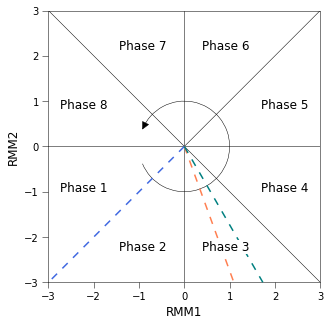

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
                       constrained_layout=False)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(length=6, width=0.5)

ax.set_xlim(-3., 3.)
ax.set_xticks(np.arange(-3, 4))
ax.set_xticklabels(f'−{-x:d}' if x < 0 else f'{x:d}'
                   for x in np.arange(-3, 4))
ax.set_xlabel('RMM1', fontsize='large')
ax.set_ylim(-3., 3.)
ax.set_yticks(np.arange(-3, 4))
ax.set_yticklabels(f'−{-y:d}' if y < 0 else f'{y:d}'
                   for y in np.arange(-3, 4))
ax.set_ylabel('RMM2', fontsize='large')

ax.set_aspect(1)

ax.axhline(color='0.', linewidth=0.5)
ax.axvline(color='0.', linewidth=0.5)
ax.plot([0, 3], [0, 3], linewidth=0.5, color='0.')
ax.plot([-3, 3], [3, -3], linewidth=0.5, color='0.')

ax.plot([0, -3 / np.tan(np.pi * ip_rmm_angle/180)], [0, -3], linewidth=1.5,
        linestyle=(0, (5, 5)), color='coral', clip_on=False, zorder = 4)
ax.plot([0, -3 / np.tan(np.pi * pg_rmm_angle/180)], [0, -3], linewidth=1.5,
        linestyle=(0, (5, 5)), color='royalblue', clip_on=False, zorder = 4)
ax.plot([0, -3 / np.tan(np.pi * olr_rmm_angle/180)], [0, -3], linewidth=1.5,
        linestyle=(0, (5, 5)), color='teal', clip_on=False, zorder = 4)

for i in range(8):
    ax.text(0.5 + 0.4 * np.cos(np.pi * (1 + i/4 + 1/8)),
            0.5 + 0.4 * np.sin(np.pi * (1 + i/4 + 1/8)),
            f'Phase {i + 1}', fontsize='large', ha='center', va='center',
            transform=ax.transAxes, zorder = 5,
            bbox=dict(edgecolor='1.', facecolor='1.', boxstyle='square, pad=0.'))

ang = np.pi * 7/8
d = 0.1
coef = 1.5
th = np.arcsin(coef * d / 2)
P = Path.arc(-ang * 180/np.pi, ang * 180/np.pi)
ax.add_patch(PathPatch(P, fill=False, linewidth=0.5))
ax.arrow(np.cos(ang) + d * np.sin(ang - th),
         np.sin(ang) - d * np.cos(ang - th),
         -d * np.sin(ang - th),
         d * np.cos(ang - th),
         linewidth=0.5, color='0.', head_width=coef*d,
         head_length=coef*d, length_includes_head=True)

fig.savefig('figures/rmm_diagram.eps', bbox_inches='tight')
fig.savefig('figures/rmm_diagram.png', dpi=300, bbox_inches='tight')

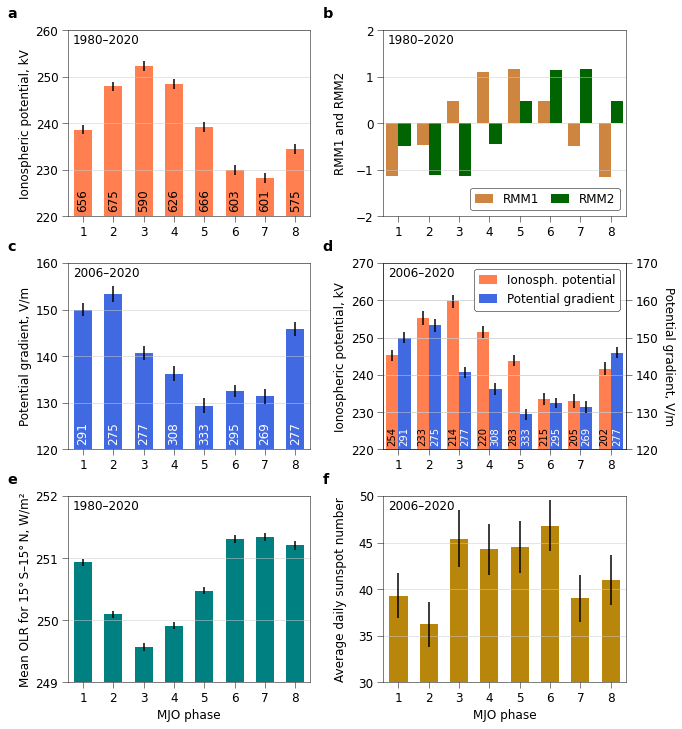

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 12),
                       constrained_layout=False)

for i in range(3):
    for j in range(2):
        for axis in ['top', 'bottom', 'left', 'right']:
            ax[i, j].spines[axis].set_linewidth(0.5)
        ax[i, j].tick_params(length=6, width=0.5)

        ax[i, j].set_xlim(0.5, 8.5)
        ax[i, j].set_xticks(np.arange(1, 9))
        ax[i, j].set_xticklabels(np.arange(1, 9).astype(int),
                                 fontsize='large')

        if i == 2:
            ax[i, j].set_xlabel('MJO phase', fontsize='large')

        ax[i, j].grid(color='0.8', linewidth=0.5, axis='y')

ax1 = ax[1, 1].twinx()
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(0.5)
ax1.tick_params(length=6, width=0.5)
ax1.grid(color='0.8', linewidth=0.5, axis='y')

ax[0, 0].set_ylim(220, 260)
ax[0, 0].set_yticks(np.arange(220, 261, 10))
ax[0, 0].set_yticklabels([f'{y:d}' for y in np.arange(220, 261, 10)],
                         fontsize='large')
ax[0, 0].set_ylabel('Ionospheric potential, kV', fontsize='large')

ax[0, 1].set_ylim(-2, 2)
ax[0, 1].set_yticks(np.arange(-2, 3, 1))
ax[0, 1].set_yticklabels([f'−{-y:d}' if y < 0 else f'{y:d}'
                          for y in np.arange(-2, 3, 1)],
                         fontsize='large')
ax[0, 1].set_ylabel('RMM1 and RMM2', fontsize='large')

ax[1, 0].set_ylim(120, 160)
ax[1, 0].set_yticks(np.arange(120, 161, 10))
ax[1, 0].set_yticklabels([f'{y:d}' for y in np.arange(120, 161, 10)],
                         fontsize='large')
ax[1, 0].set_ylabel('Potential gradient, V/m', fontsize='large')

ax[1, 1].set_ylim(220, 270)
ax[1, 1].set_yticks(np.arange(220, 271, 10))
ax[1, 1].set_yticklabels([f'{y:d}' for y in np.arange(220, 271, 10)],
                         fontsize='large')
ax[1, 1].set_ylabel('Ionospheric potential, kV', fontsize='large')
ax1.set_ylim(120, 170)
ax1.set_yticks(np.arange(120, 171, 10))
ax1.set_yticklabels([f'{y:d}' for y in np.arange(120, 171, 10)],
                      fontsize='large')
ax1.set_ylabel('Potential gradient, V/m', fontsize='large',
              rotation=270, va='bottom')

ax[2, 0].set_ylim(249, 252)
ax[2, 0].set_yticks(np.arange(249, 253, 1))
ax[2, 0].set_yticklabels([f'{y:d}' for y in np.arange(249, 253, 1)],
                         fontsize='large')
ax[2, 0].set_ylabel('Mean OLR for 15° S–15° N, W/m²', fontsize='large')
# thin spaces after '°'

ax[2, 1].set_ylim(30, 50)
ax[2, 1].set_yticks(np.arange(30, 51, 5))
ax[2, 1].set_yticklabels([f'{y:d}' for y in np.arange(30, 51, 5)],
                         fontsize='large')
ax[2, 1].set_ylabel('Average daily sunspot number', fontsize='large')

for j in range(2):
    fig.align_ylabels([ax[i, j] for i in range(3)])

for j in range(2):
    ax[0, j].text(0.02, 0.98, '1980–2020', ha='left', va='top',
                  transform=ax[0, j].transAxes, fontsize='large')
    ax[1, j].text(0.02, 0.98, '2006–2020', ha='left', va='top',
                  transform=ax[1, j].transAxes, fontsize='large')
ax[2, 0].text(0.02, 0.98, '1980–2020', ha='left', va='top',
                  transform=ax[2, 0].transAxes, fontsize='large')
ax[2, 1].text(0.02, 0.98, '2006–2020', ha='left', va='top',
                  transform=ax[2, 1].transAxes, fontsize='large')
                    
ax[0, 0].bar(np.arange(1, 9), phase_avg_ip / 1e3,
             yerr=std_error(phase_avg_ip, phase_avg_sqr_ip, counter_ip) / 1e3,
             width=0.6, color='coral')

ax[0, 1].bar(np.arange(1, 9) - 0.2, phase_avg_rmm1,
             width=0.4, color='peru', label='RMM1')
ax[0, 1].bar(np.arange(1, 9) + 0.2, phase_avg_rmm2,
             width=0.4, color='darkgreen', label='RMM2')

ax[1, 0].bar(np.arange(1, 9), phase_avg_pg,
             yerr=std_error(phase_avg_pg, phase_avg_sqr_pg, counter_pg),
             width=0.6, color='royalblue')

ax[1, 1].bar(np.arange(1, 9) - 0.2, phase_avg_ip_pg / 1e3,
             yerr=std_error(phase_avg_ip_pg, phase_avg_sqr_ip_pg, counter_ip_pg) / 1e3,
             width=0.4, color='coral', label='Ionosph. potential')
ax1.bar(np.arange(1, 9) + 0.2, phase_avg_pg,
        yerr=std_error(phase_avg_pg, phase_avg_sqr_pg, counter_pg),
        width=0.4, color='royalblue', label='Potential gradient')

ax[2, 0].bar(np.arange(1, 9), phase_avg_olr,
             yerr=std_error(phase_avg_olr, phase_avg_sqr_olr, counter_olr),
             width=0.6, color='teal')

ax[2, 1].bar(np.arange(1, 9), phase_avg_sn,
             yerr=std_error(phase_avg_sn, phase_avg_sqr_sn, counter_sn),
             width=0.6, color='darkgoldenrod')

leg = ax[0, 1].legend(fontsize='large', framealpha=1, edgecolor='0.',
                      ncol=2, columnspacing=1., loc='lower right', handlelength=1.5)
leg.get_frame().set_linewidth(0.5)

handles, labels = [(a + b) for a, b in
                   zip(ax[1, 1].get_legend_handles_labels(),
                       ax1.get_legend_handles_labels())]
leg = ax1.legend(handles, labels,
                 fontsize='large', framealpha=1, edgecolor='0.', handlelength=1.5)
leg.get_frame().set_linewidth(0.5)

for p in range(1, 9):
    ax[0, 0].annotate(str(counter_ip[p-1]), xy = (p, 221),
                      ha='center', va='bottom', rotation=90,
                      fontsize='large', color='0.')
    ax[1, 0].annotate(str(counter_pg[p-1]), xy = (p, 121),
                      ha='center', va='bottom', rotation=90,
                      fontsize='large', color='1.')
    ax[1, 1].annotate(str(counter_ip_pg[p-1]), xy = (p - 0.2, 221),
                      ha='center', va='bottom', rotation=90,
                      fontsize='medium', color='0.')
    ax1.annotate(str(counter_pg[p-1]), xy = (p + 0.2, 121),
                 ha='center', va='bottom', rotation=90,
                 fontsize='medium', color='1.')

for i in range(3):
    for j in range(2):
        ax[i, j].text(-0.25, 1.05, chr(ord('a') + 2 * i + j), fontsize='x-large',
                      fontweight='semibold', ha='left', va='bottom',
                      transform=ax[i, j].transAxes)

fig.subplots_adjust(hspace=0.25, wspace=0.3)

fig.savefig('figures/ip_pg_rmm_variation.eps', bbox_inches='tight')
fig.savefig('figures/ip_pg_rmm_variation.png', dpi=300, bbox_inches='tight')

In [21]:
print('Largest positive IP deviation from the long-term mean: '
      f'{np.amax(phase_avg_ip) - 240e3}.')
print('Largest negative IP deviation from the long-term mean: '
      f'{np.amin(phase_avg_ip) - 240e3}.')

Largest positive IP deviation from the long-term mean: 12251.515085229592.
Largest negative IP deviation from the long-term mean: -11782.171890650236.


In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10.5),
                       constrained_layout=False)

for i in range(3):
    for j in range(2):
        for axis in ['top', 'bottom', 'left', 'right']:
            ax[i, j].spines[axis].set_linewidth(0.5)
        ax[i, j].tick_params(length=6, width=0.5)

        ax[i, j].set_xlim(0.5, 8.5)
        ax[i, j].set_xticks(np.arange(1, 9))
        ax[i, j].set_xticklabels(np.arange(1, 9).astype(int), fontsize='large')

        if i == 2:
            ax[i, j].set_xlabel('MJO phase', fontsize='large')

        ax[i, j].grid(color='0.8', linewidth=0.5, axis='y')

ax[0, 0].set_ylim(210, 260)
ax[0, 0].set_yticks(np.arange(210, 261, 10))
ax[0, 0].set_yticklabels([f'{y:d}' for y in np.arange(210, 261, 10)],
                         fontsize='large')

ax[0, 1].set_ylim(200, 250)
ax[0, 1].set_yticks(np.arange(200, 251, 10))
ax[0, 1].set_yticklabels([f'{y:d}' for y in np.arange(200, 251, 10)],
                         fontsize='large')

ax[1, 0].set_ylim(220, 270)
ax[1, 0].set_yticks(np.arange(220, 271, 10))
ax[1, 0].set_yticklabels([f'{y:d}' for y in np.arange(220, 271, 10)],
                         fontsize='large')

ax[1, 1].set_ylim(220, 270)
ax[1, 1].set_yticks(np.arange(220, 271, 10))
ax[1, 1].set_yticklabels([f'{y:d}' for y in np.arange(220, 271, 10)],
                         fontsize='large')

ax[2, 0].set_ylim(120, 170)
ax[2, 0].set_yticks(np.arange(120, 171, 10))
ax[2, 0].set_yticklabels([f'{y:d}' for y in np.arange(120, 171, 10)],
                         fontsize='large')

ax[2, 1].set_ylim(110, 160)
ax[2, 1].set_yticks(np.arange(110, 161, 10))
ax[2, 1].set_yticklabels([f'{y:d}' for y in np.arange(110, 161, 10)],
                         fontsize='large')

for i in range(2):
    ax[i, 0].set_ylabel('Ionospheric potential, kV', fontsize='large')
ax[2, 0].set_ylabel('Potential gradient, V/m', fontsize='large')

for j in range(2):
    fig.align_ylabels([ax[i, j] for i in range(3)])

for k in range(4):
    ax[k // 2, k % 2].text(0.02, 0.98, f'{1981 + 10*k}–{1990 + 10*k}',
                           ha='left', va='top',
                           transform=ax[k // 2, k % 2].transAxes,
                           fontsize='large')
ax[2, 0].text(0.02, 0.98, '2006–2015', ha='left', va='top',
              transform=ax[2, 0].transAxes, fontsize='large')
ax[2, 1].text(0.02, 0.98, '2011–2020', ha='left', va='top',
              transform=ax[2, 1].transAxes, fontsize='large')

for k in range(4):
    ax[k // 2, k % 2].bar(np.arange(1, 9), phase_avg_ip_part[k] / 1e3,
                          yerr=std_error(phase_avg_ip_part[k],
                                         phase_avg_sqr_ip_part[k],
                                         counter_ip_part[k]) / 1e3,
                          width=0.6, color='coral')

for j in range(2):
    ax[2, j].bar(np.arange(1, 9), phase_avg_pg_part[j],
                          yerr=std_error(phase_avg_pg_part[j],
                                         phase_avg_sqr_pg_part[j],
                                         counter_pg_part[j]),
                          width=0.6, color='royalblue')

for p in range(1, 9):
    ax[0, 0].annotate(str(counter_ip_part[0, p-1]), xy = (p, 211),
                      ha='center', va='bottom', rotation=90,
                      fontsize='large', color='0.')
    ax[0, 1].annotate(str(counter_ip_part[1, p-1]), xy = (p, 201),
                      ha='center', va='bottom', rotation=90,
                      fontsize='large', color='0.')
    ax[1, 0].annotate(str(counter_ip_part[2, p-1]), xy = (p, 221),
                      ha='center', va='bottom', rotation=90,
                      fontsize='large', color='0.')
    ax[1, 1].annotate(str(counter_ip_part[3, p-1]), xy = (p, 221),
                      ha='center', va='bottom', rotation=90,
                      fontsize='large', color='0.')
    ax[2, 0].annotate(str(counter_pg_part[0, p-1]), xy = (p, 121),
                      ha='center', va='bottom', rotation=90,
                      fontsize='large', color='1.')
    ax[2, 1].annotate(str(counter_pg_part[1, p-1]), xy = (p, 111),
                      ha='center', va='bottom', rotation=90,
                      fontsize='large', color='1.')

for i in range(3):
    ax[i, 0].text(-0.25, 1.05, chr(ord('a') + 2*i), fontsize='x-large',
                  fontweight='semibold', ha='left', va='bottom',
                  transform=ax[i, 0].transAxes)
    ax[i, 1].text(-0.18, 1.05, chr(ord('a') + 2*i + 1), fontsize='x-large',
                  fontweight='semibold', ha='left', va='bottom',
                  transform=ax[i, 1].transAxes)

fig.subplots_adjust(hspace=0.25, wspace=0.25)

fig.savefig('figures/ip_pg_variation_partial.eps', bbox_inches='tight')
fig.savefig('figures/ip_pg_variation_partial.png', dpi=300, bbox_inches='tight')